In [2]:
import pandas as pd

In [142]:
df = pd.read_csv('../dataset/TAB_Betting_Data_cleaned.csv').drop(columns=['Unnamed: 0'])

In [3]:
df.dtypes

DATE_DIM                 object
DAY_OF_WEEK              object
BET_ACCOUNT_NUM_HASH      int64
AGE                     float64
AGE_BAND                 object
GENDER                   object
TENURE_IN_DAYS            int64
RESIDENTIAL_STATE        object
FOB_RACING_TURNOVER     float64
FOB_SPORT_TURNOVER      float64
PARI_RACING_TURNOVER    float64
PARI_SPORT_TURNOVER     float64
TOTAL_TURNOVER          float64
DIVIDENDS_PAID          float64
GROSS_MARGIN            float64
TICKETS                   int64
DAY_OF_WEEK_FULL         object
GENDER_FULL              object
dtype: object

In [143]:
df['DATE_DIM']=pd.to_datetime(df['DATE_DIM'])

## Building model

Nhiệm vụ là xây dựng mô hình dự đoán bằng cách sử dụng bộ dữ liệu để dự đoán tổng doanh thu trên mỗi khách hàng, giúp sử dụng ngân sách tiếp thị (marketing budget) tốt hơn, đồng thời giải thích yếu tố tác động nhiều nhất đến dự đoán tổng doanh thu bằng các mô hình khác nhau.

Xây dựng mô hình phân loại để dự đoán liệu người dùng thực hiện đặt cược hay không trong khoảng thời gian nhất định và sau đó giả sử nếu có khả năng khách hàng đặt cượt thì bằng mô hình hồi quy, chúng tôi sẽ dự đoán doanh thu sẽ được tạo ra bởi khách hàng.

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
# from IPython.display import Image

1. Dự đoán doanh thu do khách hàng tạo ra. Vì vậy chúng ta có thể coi vấn đề này là vấn đề hồi quy.

2. Đầu tiên, xây dựng một mô hình phân loại để dự đoán liệu người dùng thực hiện đặt cược hay không trong thời gian thử nghiệm và sau đó giả sử nếu có khả năng anh ta sẽ đặt cược thì bằng cách sử dụng mô hình hồi quy, chúng tôi sẽ dự đoán doanh thu sẽ được tạo ra bởi khách hàng.

3. Việc giải quyết vấn đề Phân loại + Hồi quy được thúc đẩy bởi Mô hình Hurdle (https://seananderson.ca/2014/05/18/gamma-hurdle/).

Hurdle Model: Nó khuyến nghị giải quyết vấn đề bằng cách 1. Phân loại xem giá trị có khác 0 hay không 2. Và sau đó dự đoán số tiền.

Chỉ số đo hiệu suất của mô hình:
1. Chúng ta sẽ dự đoán logarit tự nhiên(ln) của tổng tất cả các giao dịch theo từng người dùng.
2. Vì vậy số liệu phù hợp cho các vấn đề hồi quy là RMSE. nên ngay cả Kaggle cũng đưa ra thước đo đánh giá là RMSE.
3. transaction_of_user_i = log(1+ all transactions of user_i)

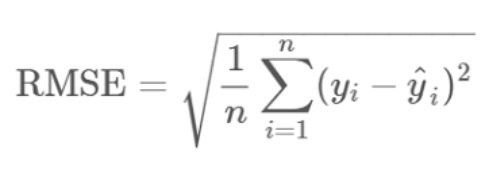

## Train and Test datasets

In [144]:
df = df.sort_values(by='DATE_DIM',ascending=True)

In [145]:
train_df = df[:round(df.shape[0]*0.8)].drop(columns=['AGE', 'DAY_OF_WEEK', 'GENDER']).reset_index(drop=True)
test_df = df[round(df.shape[0]*0.8)+1:-1].drop(columns=['AGE', 'DAY_OF_WEEK', 'GENDER']).reset_index(drop=True)

In [ ]:
train_df.head()

,DATE_DIM,BET_ACCOUNT_NUM_HASH,AGE_BAND,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,DAY_OF_WEEK_FULL,GENDER_FULL
0,2021-01-01,13154,65+,11846,WA,37.0,0.0,1081.0,0.0,1118.0,443.55,271.254275,288,Friday,Male
1,2021-01-01,2851765035,18-24,90,WA,24.0,0.0,6.0,0.0,30.0,0.00,25.500439,4,Friday,Undefined
2,2021-01-01,2851610972,45-54,8606,WA,0.0,0.0,100.0,0.0,100.0,160.00,15.343696,1,Friday,Male
3,2021-01-01,2851609211,45-54,1351,WA,120.0,0.0,560.0,0.0,680.0,806.00,-48.159718,26,Friday,Male
4,2021-01-01,2851587532,65+,6631,WA,50.0,0.0,108.0,0.0,158.0,187.24,-14.943126,64,Friday,Male


1. train data : dữ liệu giao dịch từ ngày 1 tháng 1 năm 2021 đến ngày 16 tháng 8 năm 2022
2. test data : dữ liệu giao dịch từ ngày 16 tháng 8 năm 2022 đến ngày 31 tháng 12 năm 2023

## Feature engineering

In [ ]:
train_df.dtypes

DATE_DIM                datetime64[ns]
BET_ACCOUNT_NUM_HASH             int64
AGE_BAND                        object
TENURE_IN_DAYS                   int64
RESIDENTIAL_STATE               object
FOB_RACING_TURNOVER            float64
FOB_SPORT_TURNOVER             float64
PARI_RACING_TURNOVER           float64
PARI_SPORT_TURNOVER            float64
TOTAL_TURNOVER                 float64
DIVIDENDS_PAID                 float64
GROSS_MARGIN                   float64
TICKETS                          int64
DAY_OF_WEEK_FULL                object
GENDER_FULL                     object
dtype: object

In [146]:
# Numerical features
numeric_feat = ['TENURE_IN_DAYS', 'FOB_RACING_TURNOVER', 'FOB_SPORT_TURNOVER', 'PARI_RACING_TURNOVER', 'PARI_RACING_TURNOVER', 'TOTAL_TURNOVER', 'DIVIDENDS_PAID', 'TICKETS']

In [12]:
# convert numerical features to float
for col in numeric_feat:
    train_df[col] = train_df[col].astype('float')
    test_df[col] = test_df[col].astype('float')

In [13]:
# Label encoding for categorical features
# categorical features
categorical_feat = ['AGE_BAND', 'RESIDENTIAL_STATE', 'DAY_OF_WEEK_FULL', 'GENDER_FULL']
for feature in categorical_feat:
    label_encoder = preprocessing.LabelEncoder() # intitalizing label encoder object
    label_encoder.fit(list(train_df[feature].values.astype('str')) + list(test_df[feature].values.astype('str'))) # fit with list of variables in that feature
    train_df[feature] = label_encoder.transform(list(train_df[feature].values.astype('str'))) # transforming that feature
    test_df[feature]  = label_encoder.transform(list(test_df[feature].values.astype('str')))
    print("for this feature : {0} label-encoding was done succesfully".format(feature))

for this feature : AGE_BAND label-encoding was done succesfully
for this feature : RESIDENTIAL_STATE label-encoding was done succesfully
for this feature : DAY_OF_WEEK_FULL label-encoding was done succesfully
for this feature : GENDER_FULL label-encoding was done succesfully


In [14]:
# storing all label encoded data into fiels:
train_df.to_csv('../dataset/labelencoded_train.csv')
test_df.to_csv('../dataset/labelencoded_test.csv')

In [4]:
train_df = pd.read_csv('../dataset/labelencoded_train.csv').drop(columns=['Unnamed: 0'])
test_df = pd.read_csv('../dataset/labelencoded_test.csv').drop(columns=['Unnamed: 0'])

In [5]:
train_df['DATE_DIM']=pd.to_datetime(train_df['DATE_DIM'])
test_df['DATE_DIM']=pd.to_datetime(test_df['DATE_DIM'])

### Time-series featurization

Tập train có dữ liệu giao dịch gần 20 tháng (592 ngày)

Tập test có dữ liệu giao dịch gần 5 tháng (137 ngày)

Chúng ta cần phải dự đoán khách hàng có tiến hành đặt cược vào các tháng/quý tiếp theo hay không. Chia dữ liệu thành từng tập theo các kịch bản sau với tập train sẽ có thời gian khoảng thời gian là trong ba quý, tập test có khoảng thời gian trong khoảng một quý:

1. dataset 1:
  - Train: từ ngày 1 tháng 1 năm 2021 đến ngày 1 tháng 10 năm 2021 (273 ngày)
  - Test: từ ngày 2 tháng 10 năm 2021 đến ngày 2 tháng 1 năm 2022 (92 ngày)
2. dataset 2:
  - Train: từ ngày 3 tháng 1 năm 2022 đến ngày 2 tháng 10 năm 2022 (273 ngày)
  - Test: từ ngày 3 tháng 10 năm 2022 đến ngày 2 tháng 1 năm 2023 (92 ngày)

chúng tôi sẽ tạo một tính năng mới 'is_returned' và chúng tôi sẽ đặt nó thành 1, đối với những khách hàng không quay lại, chúng tôi sẽ đặt 'is_returned' thành 0.

In [ ]:
df.columns

Index(['DATE_DIM', 'DAY_OF_WEEK', 'BET_ACCOUNT_NUM_HASH', 'AGE', 'AGE_BAND',
       'GENDER', 'TENURE_IN_DAYS', 'RESIDENTIAL_STATE', 'FOB_RACING_TURNOVER',
       'FOB_SPORT_TURNOVER', 'PARI_RACING_TURNOVER', 'PARI_SPORT_TURNOVER',
       'TOTAL_TURNOVER', 'DIVIDENDS_PAID', 'GROSS_MARGIN', 'TICKETS',
       'DAY_OF_WEEK_FULL', 'GENDER_FULL'],
      dtype='object')

In [6]:
def get_time_series_features(data:pd.DataFrame,k:int):
  train_frame_k = data.loc[(data['DATE_DIM'] >= data['DATE_DIM'].min() + timedelta(days=273*(k-1))) & (data['DATE_DIM'] < data['DATE_DIM'].min() + timedelta(days=273*k)) ]
  test_frame_k = data.loc[(data['DATE_DIM'] >= train_frame_k['DATE_DIM'].max()) & (data['DATE_DIM'] <= train_frame_k['DATE_DIM'].max() + timedelta(days=92))]

  returned_customers     = set(train_frame_k["BET_ACCOUNT_NUM_HASH"]) & set(test_frame_k["BET_ACCOUNT_NUM_HASH"]) # intersection
  non_returned_customers = set(train_frame_k["BET_ACCOUNT_NUM_HASH"]) - set(test_frame_k["BET_ACCOUNT_NUM_HASH"]) # subtraction

  # preparing returned customers data
  returned_customers_data = test_frame_k[test_frame_k['BET_ACCOUNT_NUM_HASH'].isin(set(returned_customers))]
  returned_customers_transactions = returned_customers_data.groupby('BET_ACCOUNT_NUM_HASH')[['TOTAL_TURNOVER']].sum().apply(np.log1p, axis=1).reset_index()
  returned_customers_transactions['is_returned'] = 1
  returned_customers_transactions.rename(columns={'TOTAL_TURNOVER': 'revenue'}, inplace=True)

  # preparing non-returned customers data
  non_returned_customers_data = pd.DataFrame()
  non_returned_customers_data['BET_ACCOUNT_NUM_HASH'] = list(set(non_returned_customers))
  non_returned_customers_data['is_returned'] = 0
  non_returned_customers_data['revenue'] = 0

  # so final time based featurizations(for classification model)
  # we are concatinating returned and non-returned users
  classification_features = pd.concat([returned_customers_transactions,
                                        non_returned_customers_data],
                                        axis=0).reset_index(drop=True)

  # featurization for train_frame_k data
  train_frame_k_maxdate = max(train_frame_k['DATE_DIM'])
  train_frame_k_mindate = min(train_frame_k['DATE_DIM'])
  train_frame_k_1 = train_frame_k.groupby('BET_ACCOUNT_NUM_HASH').agg({
      'DAY_OF_WEEK_FULL': 'max',
      'AGE_BAND': 'max',
      'GENDER_FULL': 'max',
      'TENURE_IN_DAYS': 'max',
      'RESIDENTIAL_STATE': 'max',
      'FOB_RACING_TURNOVER': 'sum',
      'FOB_SPORT_TURNOVER': 'sum',
      'PARI_RACING_TURNOVER': 'sum',
      'PARI_SPORT_TURNOVER': 'sum',
      'DIVIDENDS_PAID': 'sum',
      'GROSS_MARGIN': 'sum',
      'TICKETS': 'sum'

  })
  train_frame_k_2 = train_frame_k.groupby('BET_ACCOUNT_NUM_HASH').agg({
      'DATE_DIM':  [('first_ses_from_the_period_start' , lambda x: x.min() - train_frame_k_mindate), #first betting session for customer after the period end date for current frame.
                ('last_ses_from_the_period_end', lambda x: train_frame_k_maxdate - x.max()), #Last betting session for customer before the period end date for current frame.
                ('interval_dates' , lambda x: x.max() - x.min()),  #interval calculated as the latest date on which customer visited - oldest date on which they visited.
                ('unqiue_date_num' , lambda x: len(set(x)))] , # Unique number of dates customer visited.

  })
  # Drop the parent level of features. for e.g. drop geoNetwork.networkDomain and keep only 'networkDomain' which stores max value from the group.
  # train_frame_k_1.columns = train_frame_k_1.columns.droplevel(1)
  train_frame_k_2.columns = train_frame_k_2.columns.droplevel()
  train_frame_k = pd.merge(train_frame_k_1,
                             train_frame_k_2 ,
                             left_on='BET_ACCOUNT_NUM_HASH',
                             right_on='BET_ACCOUNT_NUM_HASH')
  # merging the two dataframe tf having features and tf_target having target variables.
  train_frame_k = pd.merge(train_frame_k,
                             classification_features ,
                             left_on='BET_ACCOUNT_NUM_HASH',
                             right_on='BET_ACCOUNT_NUM_HASH')
  return train_frame_k

In [7]:
#Merge Train Test
train_test_data = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

In [163]:
train_test_data.head()

,DATE_DIM,BET_ACCOUNT_NUM_HASH,AGE_BAND,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,DAY_OF_WEEK_FULL,GENDER_FULL
0,2021-01-01,13154,5,11846.0,1,37.0,0.0,1081.0,0.0,1118.0,443.55,271.254275,288.0,0,1
1,2021-01-01,2851765035,0,90.0,1,24.0,0.0,6.0,0.0,30.0,0.00,25.500439,4.0,0,2
2,2021-01-01,2851610972,3,8606.0,1,0.0,0.0,100.0,0.0,100.0,160.00,15.343696,1.0,0,1
3,2021-01-01,2851609211,3,1351.0,1,120.0,0.0,560.0,0.0,680.0,806.00,-48.159718,26.0,0,1
4,2021-01-01,2851587532,5,6631.0,1,50.0,0.0,108.0,0.0,158.0,187.24,-14.943126,64.0,0,1


In [8]:
%time train_frame_1 = get_time_series_features(train_test_data,1)

Wall time: 38.2 s


In [9]:
train_frame_1

,BET_ACCOUNT_NUM_HASH,DAY_OF_WEEK_FULL,AGE_BAND,GENDER_FULL,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned
0,13154,6,5,1,12118.0,1,16935.0,0.0,210552.42,0.0,175117.22,49931.427691,67727.0,0 days,0 days,272 days,208,10.702727,1
1,18379,6,3,1,2151.0,1,7777.0,0.0,1532.00,0.0,5205.44,3360.537091,200.0,0 days,5 days,267 days,58,8.290293,1
2,368326,2,2,2,0.0,1,0.0,21.0,0.00,0.0,13.60,7.400000,6.0,267 days,5 days,0 days,1,3.135494,1
3,385032,6,1,2,2460.0,1,44.0,0.0,2.00,0.0,8.80,35.555353,10.0,109 days,37 days,126 days,7,3.044522,1
4,406536,3,2,2,831.0,1,25.0,7.0,19.50,0.0,92.30,-36.843449,22.0,37 days,228 days,7 days,3,3.178054,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91914,4294749281,6,1,2,67.0,1,0.0,0.0,35258.75,0.0,22866.62,7650.712840,11592.0,205 days,0 days,67 days,66,9.028908,1
91915,4294785920,2,3,2,357.0,1,111.0,0.0,0.00,0.0,51.00,60.000000,11.0,239 days,12 days,21 days,2,4.867534,1
91916,4294810447,6,0,2,179.0,0,8890.0,11045.0,0.00,0.0,21247.47,-1312.470000,288.0,81 days,14 days,177 days,106,7.310550,1
91917,4294834703,6,3,1,4744.0,1,57789.0,100.0,4674.50,0.0,59057.74,2995.210734,748.0,0 days,0 days,272 days,140,10.886536,1


In [127]:
train_frame_1.to_pickle('../dataset/train_frame_1')

In [128]:
%time train_frame_2 = get_time_series_features(train_test_data,2)

train_frame_2.to_pickle('../dataset/train_frame_2')

Wall time: 55.6 s


In [10]:
def get_time_series_features_for_test(test_data):

    test_frame_k_maxdate = max(test_data['DATE_DIM'])
    test_frame_k_mindate = min(test_data['DATE_DIM'])

    test_data_turnover = test_data.groupby('BET_ACCOUNT_NUM_HASH')[['TOTAL_TURNOVER']].sum().apply(np.log1p, axis=1).reset_index()
    test_data_turnover.rename(columns={'TOTAL_TURNOVER': 'revenue'}, inplace=True)
    
    test_frame_k_1 = test_data.groupby('BET_ACCOUNT_NUM_HASH').agg({
      'DAY_OF_WEEK_FULL': 'max',
      'AGE_BAND': 'max',
      'GENDER_FULL': 'max',
      'TENURE_IN_DAYS': 'max',
      'RESIDENTIAL_STATE': 'max',
      'FOB_RACING_TURNOVER': 'sum',
      'FOB_SPORT_TURNOVER': 'sum',
      'PARI_RACING_TURNOVER': 'sum',
      'PARI_SPORT_TURNOVER': 'sum',
      'DIVIDENDS_PAID': 'sum',
      'GROSS_MARGIN': 'sum',
      'TICKETS': 'sum',
    })

    test_frame_k_2 = test_data.groupby('BET_ACCOUNT_NUM_HASH').agg({
      'DATE_DIM':  [('first_ses_from_the_period_start' , lambda x: x.min() - test_frame_k_mindate), #first betting session for customer after the period end date for current frame.
                ('last_ses_from_the_period_end', lambda x: test_frame_k_maxdate - x.max()), #Last betting session for customer before the period end date for current frame.
                ('interval_dates' , lambda x: x.max() - x.min()),  #interval calculated as the latest date on which customer visited - oldest date on which they visited.
                ('unqiue_date_num' , lambda x: len(set(x)))] , # Unique number of dates customer visited.
    })

    # Drop the parent level of features. for e.g. drop geoNetwork.networkDomain and keep only 'networkDomain' which stores max value from the group.
    test_frame_k_2.columns = test_frame_k_2.columns.droplevel()
    test_frame_k = pd.merge(test_frame_k_1,
                             test_frame_k_2 ,
                             left_on='BET_ACCOUNT_NUM_HASH',
                             right_on='BET_ACCOUNT_NUM_HASH')
    test_true = pd.merge(test_frame_k,
                             test_data_turnover,
                             left_on='BET_ACCOUNT_NUM_HASH',
                             right_on='BET_ACCOUNT_NUM_HASH')

    return test_frame_k, test_true

In [11]:
%time test_frame_3, test_frame_3_true = get_time_series_features_for_test(test_df)

Wall time: 33.7 s


In [166]:
test_frame_3 = test_frame_3.reset_index()
test_frame_3_true = test_frame_3_true.reset_index()
test_frame_3['revenue'] = np.nan
test_frame_3['is_returned'] = np.nan
test_frame_3.to_pickle('../dataset/test_frame_3')
test_frame_3_true.to_pickle('../dataset/test_frame_3_true')

In [20]:
#reading pickle files:
tr1 = pd.read_pickle(r'../dataset/train_frame_1')
tr2 = pd.read_pickle(r'../dataset/train_frame_2')
tr3 = pd.read_pickle(r'../dataset/test_frame_3')

In [21]:
#concatinating all our featurized frames:
final_featurized_data = pd.concat([tr1, tr2, tr3],
                                  axis=0,
                                  sort=False).reset_index(drop=True)

In [171]:
final_featurized_data

,BET_ACCOUNT_NUM_HASH,DAY_OF_WEEK_FULL,AGE_BAND,GENDER_FULL,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned
0,13154,6,5,1,12118.0,1,16935.0,0.0,210552.42,0.0,175117.22,49931.427691,67727.0,0 days,0 days,272 days,208,10.702727,1.0
1,18379,6,3,1,2151.0,1,7777.0,0.0,1532.00,0.0,5205.44,3360.537091,200.0,0 days,5 days,267 days,58,8.290293,1.0
2,368326,2,2,2,0.0,1,0.0,21.0,0.00,0.0,13.60,7.400000,6.0,267 days,5 days,0 days,1,3.135494,1.0
3,385032,6,1,2,2460.0,1,44.0,0.0,2.00,0.0,8.80,35.555353,10.0,109 days,37 days,126 days,7,3.044522,1.0
4,406536,3,2,2,831.0,1,25.0,7.0,19.50,0.0,92.30,-36.843449,22.0,37 days,228 days,7 days,3,3.178054,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294402,4294785920,6,3,2,766.0,1,91.0,0.0,0.00,0.0,56.00,35.000000,21.0,15 days,60 days,62 days,2,NaN,NaN
294403,4294834703,6,3,1,5194.0,1,8054.5,0.0,100.00,0.0,7094.00,980.535848,89.0,5 days,7 days,125 days,30,NaN,NaN
294404,4294891076,6,5,0,3645.0,1,921.0,75.0,16341.00,0.0,13019.66,3658.069290,7567.0,1 days,1 days,135 days,113,NaN,NaN
294405,4294964456,6,0,2,0.0,1,29.0,0.0,38.00,0.0,7.40,30.326392,24.0,99 days,38 days,0 days,1,NaN,NaN


In [22]:
#Convert the date calulcated field in days format:
final_featurized_data['interval_dates'] = final_featurized_data['interval_dates'].dt.days
final_featurized_data['first_ses_from_the_period_start'] = final_featurized_data['first_ses_from_the_period_start'].dt.days
final_featurized_data['last_ses_from_the_period_end'] = final_featurized_data['last_ses_from_the_period_end'].dt.days

In [173]:
final_featurized_data.to_pickle('../dataset/final_featurized_data')

In [23]:
# for all our test records we already fill the 'revenue' column with 'null' values. So here we are seperating our train and test records
train_df = final_featurized_data[final_featurized_data['revenue'].notnull()]
test_df  = final_featurized_data[final_featurized_data['revenue'].isnull()]

## Model building

### MLP

In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint
from keras import optimizers

In [18]:
target_columns = ['is_returned', 'revenue', 'BET_ACCOUNT_NUM_HASH']

In [177]:
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.0006

In [178]:
model_classification = Sequential()
model_classification.add(Dense(256,
                               kernel_initializer='glorot_normal',
                               activation='relu',
                               input_dim=16))

model_classification.add(Dense(128,
                               kernel_initializer='glorot_normal',
                               activation='relu'))

model_classification.add(Dense(1,activation='sigmoid'))

In [179]:
adam = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [180]:
model_classification.compile(loss='binary_crossentropy', optimizer=adam)

In [181]:
model_classification.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               4352      
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 37,377
Trainable params: 37,377
Non-trainable params: 0
_________________________________________________________________


In [182]:
train_df

,BET_ACCOUNT_NUM_HASH,DAY_OF_WEEK_FULL,AGE_BAND,GENDER_FULL,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned
0,13154,6,5,1,12118.0,1,16935.0,0.0,210552.42,0.0,175117.22,49931.427691,67727.0,0,0,272,208,10.702727,1.0
1,18379,6,3,1,2151.0,1,7777.0,0.0,1532.00,0.0,5205.44,3360.537091,200.0,0,5,267,58,8.290293,1.0
2,368326,2,2,2,0.0,1,0.0,21.0,0.00,0.0,13.60,7.400000,6.0,267,5,0,1,3.135494,1.0
3,385032,6,1,2,2460.0,1,44.0,0.0,2.00,0.0,8.80,35.555353,10.0,109,37,126,7,3.044522,1.0
4,406536,3,2,2,831.0,1,25.0,7.0,19.50,0.0,92.30,-36.843449,22.0,37,228,7,3,3.178054,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193705,4294810447,6,0,2,462.0,0,1495.0,380.0,0.00,0.0,1709.50,165.500000,38.0,5,4,263,14,3.713572,1.0
193706,4294834703,6,3,1,5016.0,1,95945.0,0.0,7247.30,0.0,74469.56,27877.136934,1048.0,0,1,271,160,7.868254,1.0
193707,4294891076,6,5,0,3462.0,1,168.0,170.0,31800.25,13.0,23494.44,6783.535796,13972.0,0,0,272,205,9.369436,1.0
193708,4294928673,5,2,2,728.0,1,1.0,0.0,7.00,0.0,0.00,2.380160,4.0,32,240,0,1,0.000000,0.0


In [92]:
history = model_classification.fit(x = train_df.drop(target_columns, axis=1) ,
                                   y=train_df['is_returned'],
                                   batch_size=BATCH_SIZE,
                                   epochs=25,
                                   verbose=1)

Epoch 1/25
3027/3027 [==============================] - 12s 3ms/step - loss: 18.0391
Epoch 2/25
3027/3027 [==============================] - 10s 3ms/step - loss: 3.7992
Epoch 3/25
3027/3027 [==============================] - 10s 3ms/step - loss: 1.5076
Epoch 4/25
3027/3027 [==============================] - 10s 3ms/step - loss: 0.7159
Epoch 5/25
3027/3027 [==============================] - 9s 3ms/step - loss: 0.4970
Epoch 6/25
3027/3027 [==============================] - 9s 3ms/step - loss: 0.3959
Epoch 7/25
3027/3027 [==============================] - 10s 3ms/step - loss: 0.3617
Epoch 8/25
3027/3027 [==============================] - 10s 3ms/step - loss: 0.3629
Epoch 9/25
3027/3027 [==============================] - 10s 3ms/step - loss: 0.3560
Epoch 10/25
3027/3027 [==============================] - 10s 3ms/step - loss: 0.3555
Epoch 11/25
3027/3027 [==============================] - 10s 3ms/step - loss: 0.3513
Epoch 12/25
3027/3027 [==============================] - 10s 3ms/step - los

In [105]:
model_classification.save('./saved_model/model_classification')

INFO:tensorflow:Assets written to: ./saved_model/model_classification\assets


In [93]:
model_regression = Sequential()

model_regression.add(Dense(256,
                           kernel_initializer='glorot_normal',
                           activation='relu',
                           input_dim=16))

model_regression.add(Dense(128,
                           kernel_initializer='glorot_normal',
                           activation='relu'))

model_regression.add(Dense(1))

In [94]:
adam = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [95]:
model_regression.compile(loss='mse', optimizer=adam)

In [96]:
model_regression.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               4352      
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 37,377
Trainable params: 37,377
Non-trainable params: 0
_________________________________________________________________


In [97]:
history = model_regression.fit(x=train_df.drop(target_columns, axis=1)[train_df['is_returned']==1],
                               y= train_df['revenue'][train_df['is_returned']==1],
                               batch_size=BATCH_SIZE,
                               epochs=EPOCHS,
                               verbose=1)

Epoch 1/100
2028/2028 [==============================] - 8s 3ms/step - loss: 1870506.5000
Epoch 2/100
2028/2028 [==============================] - 6s 3ms/step - loss: 1482163.1250
Epoch 3/100
2028/2028 [==============================] - 6s 3ms/step - loss: 704843.9375
Epoch 4/100
2028/2028 [==============================] - 6s 3ms/step - loss: 983805.5000
Epoch 5/100
2028/2028 [==============================] - 6s 3ms/step - loss: 428616.2812
Epoch 6/100
2028/2028 [==============================] - 6s 3ms/step - loss: 317231.4062
Epoch 7/100
2028/2028 [==============================] - 6s 3ms/step - loss: 57737.5273
Epoch 8/100
2028/2028 [==============================] - 6s 3ms/step - loss: 38914.9727
Epoch 9/100
2028/2028 [==============================] - 6s 3ms/step - loss: 51536.0273
Epoch 10/100
2028/2028 [==============================] - 6s 3ms/step - loss: 16607.8516
Epoch 11/100
2028/2028 [==============================] - 6s 3ms/step - loss: 6950.1064
Epoch 12/100
2028/2028 

In [107]:
classification_predictions = model_classification.predict(test_df.drop(target_columns, axis=1))

3147/3147 [==============================] - 6s 2ms/step


In [16]:
classification_model = tf.keras.models.load_model('E:\\Data Got Talent\\notebooks\\saved_model\\model_classification')
regression_model = tf.keras.models.load_model('E:\\Data Got Talent\\notebooks\\saved_model\\model_regression')
    

In [24]:
classification_model.predict(test_df.drop(target_columns, axis=1))

3147/3147 [==============================] - 6s 2ms/step


array([[0.9993208 ],
       [0.9728486 ],
       [0.15734924],
       ...,
       [0.9967344 ],
       [0.25328463],
       [0.5434025 ]], dtype=float32)

In [189]:
classification_predictions

array([[0.9993208 ],
       [0.9728486 ],
       [0.15734924],
       ...,
       [0.9967344 ],
       [0.25328463],
       [0.5434025 ]], dtype=float32)

In [108]:
regression_predictions = model_regression.predict(test_df.drop(target_columns, axis=1))

3147/3147 [==============================] - 6s 2ms/step


In [109]:
regression_predictions[regression_predictions<0] = 0

In [110]:
val_predictions = classification_predictions*regression_predictions

In [106]:
model_regression.save('./saved_model/model_regression')

INFO:tensorflow:Assets written to: ./saved_model/model_regression\assets


In [111]:
pred_df = pd.DataFrame({"BET_ACCOUNT_NUM_HASH":test_df["BET_ACCOUNT_NUM_HASH"].values})

In [112]:
pred_df["PredictedLogRevenue"] = val_predictions

In [192]:
pred_df['PredictedIsReturn'] = classification_predictions

In [113]:
pred_df.columns = ["BET_ACCOUNT_NUM_HASH", "PredictedLogRevenue"]

In [193]:
pred_df

,BET_ACCOUNT_NUM_HASH,PredictedLogRevenue,PredictedIsReturn
0,13154,9.358683,0.999321
1,18379,8.349029,0.972849
2,37251,0.702399,0.157349
3,129273,2.901252,0.637405
4,348318,1.601856,0.356687
...,...,...,...
100692,4294785920,2.237966,0.490359
100693,4294834703,7.294991,0.919039
100694,4294891076,9.334461,0.996734
100695,4294964456,1.206844,0.253285


In [194]:
res = pd.merge(pred_df, 
               test_frame_3_true, 
               left_on='BET_ACCOUNT_NUM_HASH', 
               right_on='BET_ACCOUNT_NUM_HASH') 

In [195]:
res

,BET_ACCOUNT_NUM_HASH,PredictedLogRevenue,PredictedIsReturn,index,DAY_OF_WEEK_FULL,AGE_BAND,GENDER_FULL,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,...,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue
0,13154,9.358683,0.999321,0,6,5,1,12575.0,1,3783.0,...,28569.64,0.0,20444.82,7869.244903,11493.0,1 days,0 days,136 days,78,10.384482
1,18379,8.349029,0.972849,1,6,3,1,2613.0,1,8229.0,...,499.00,0.0,7633.16,826.211250,285.0,4 days,0 days,133 days,52,9.074406
2,37251,0.702399,0.157349,2,5,0,2,0.0,1,65.0,...,35.00,0.0,760.00,-689.654776,7.0,77 days,60 days,0 days,1,4.615121
3,129273,2.901252,0.637405,3,5,0,2,358.0,1,17.0,...,0.00,0.0,111.25,-54.250000,10.0,18 days,12 days,107 days,7,4.060443
4,348318,1.601856,0.356687,4,2,1,2,106.0,1,5.0,...,0.00,0.0,0.00,10.000000,6.0,38 days,98 days,1 days,2,2.397895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100692,4294785920,2.237966,0.490359,100692,6,3,2,766.0,1,91.0,...,0.00,0.0,56.00,35.000000,21.0,15 days,60 days,62 days,2,4.521789
100693,4294834703,7.294991,0.919039,100693,6,3,1,5194.0,1,8054.5,...,100.00,0.0,7094.00,980.535848,89.0,5 days,7 days,125 days,30,9.006448
100694,4294891076,9.334461,0.996734,100694,6,5,0,3645.0,1,921.0,...,16341.00,0.0,13019.66,3658.069290,7567.0,1 days,1 days,135 days,113,9.760656
100695,4294964456,1.206844,0.253285,100695,6,0,2,0.0,1,29.0,...,38.00,0.0,7.40,30.326392,24.0,99 days,38 days,0 days,1,4.219508


In [188]:
rms = np.sqrt(mean_squared_error(res['revenue'], res['PredictedLogRevenue']))
rms

2.307626697887556